# Antarctic SMB trends

Author: Ziqi Yin

Last edited: Feb 14, 2025

## Description

- Data: MT19; CESM2-LEcmip6
    - MT19: SMB reconstruction of Medley and Thomas, 2019
    - OC24: surface sea level pressure reconstruction
    - OC21: surface air temperature reconstruction
    - CESM2-GOGA: find global atmospheric response to observed SST and sea ice anomalies globally
    - ERSSTv5: observed sea surface temperature
    - CESM2-LEcmip6: Large Ensemble (LE) using the 50 members that have original CMIP6 biomass burning aerosols
- Period: 1901-1970

In [1]:
# Load Libraries
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cartopy.util as util
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.stats import linregress
import matplotlib.path as mpath
import matplotlib.colors as colors

import sys
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')

from functions import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
### --- Plot basemap of Antarctica with cartopy --- ###
def plot_antarctica_SO(ax, lat):
    coast_line = gpd.read_file('/glade/work/ziqiyin/shp_files/Coastline_Antarctica_v2.shp')
    grounding_line = gpd.read_file('/glade/work/ziqiyin/shp_files/GroundingLine_Antarctica_v2.shp')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.51
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.add_geometries(coast_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='none', edgecolor='black', linewidth = 0.5)
    #ax.add_geometries(grounding_line['geometry'], crs = ccrs.SouthPolarStereo(central_longitude=0), facecolor='white', edgecolor='black', linewidth = 0.5)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, lat], ccrs.PlateCarree())
    return

## Read data

In [3]:
## SMB variables
# MT19 (1801-2000)
path = '/glade/work/dschneid/zaria_snow/'

fn_SMB_MT = 'merra_medley_regrid.nc'
SMB_MT = xr.open_dataset(path+fn_SMB_MT).smb
lat_MT = np.array(SMB_MT.lat)
lon_MT = np.array(SMB_MT.lon)

# CESM2-LE (50 cmip6 members, 1850-2100)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/large_ensemble_CESM2/CMIP6_subset/'

fn_RAIN_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.RAIN.185001-210012.nc'
RAIN_LE = xr.open_dataset(path+fn_RAIN_LE).RAIN #[mm/s]
lon = RAIN_LE.lon
lat = RAIN_LE.lat
fn_SNOW_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.SNOW.185001-210012.nc'
SNOW_LE = xr.open_dataset(path+fn_SNOW_LE).SNOW
fn_QSOIL_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.QSOIL.185001-210012.nc'
QSOIL_LE = xr.open_dataset(path+fn_QSOIL_LE).QSOIL
fn_QRUNOFF_LE = 'b.e21.BHISTcmip6.f09_g17.LE2.EM1-50.clm2.h0.QRUNOFF.185001-210012.nc'
QRUNOFF_LE = xr.open_dataset(path+fn_QRUNOFF_LE).QRUNOFF
SMB_LE = RAIN_LE + SNOW_LE - QSOIL_LE - QRUNOFF_LE

#CESM2-GOGA (10 members, 1880-2021)
path = '/glade/campaign/cgd/cas/dschneid/SMB_variables_CESM2/GOGA/'

fn_RAIN_GOGA = 'f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.EM1-10.clm2.h0.RAIN.188001-202112.nc'
RAIN_GOGA = xr.open_dataset(path+fn_RAIN_GOGA).RAIN
fn_SNOW_GOGA = 'f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.EM1-10.clm2.h0.SNOW.188001-202112.nc'
SNOW_GOGA = xr.open_dataset(path+fn_SNOW_GOGA).SNOW
fn_QSOIL_GOGA = 'f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.EM1-10.clm2.h0.QSOIL.188001-202112.nc'
QSOIL_GOGA = xr.open_dataset(path+fn_QSOIL_GOGA).QSOIL
fn_QRUNOFF_GOGA = 'f.e21.FHIST_BGC.f09_f09.historical.ersstv5.goga.EM1-10.clm2.h0.QRUNOFF.188001-202112.nc'
QRUNOFF_GOGA = xr.open_dataset(path+fn_QRUNOFF_GOGA).QRUNOFF
SMB_GOGA = RAIN_GOGA + SNOW_GOGA - QSOIL_GOGA - QRUNOFF_GOGA

In [6]:
## Zwally grounded ice sheet land mask (REMOVAL of ice shelves)
path = '/glade/work/dschneid/zaria_snow/'

fn_GROUNDEDMASK = 'AIS_Groundedmask_Zwally_CESMgrid.nc'
GROUNDEDMASK = xr.open_dataset(path+fn_GROUNDEDMASK).Groundedmask

# Select lat range
GROUNDEDMASK_sel = GROUNDEDMASK.sel(lat=slice(-90,-60))

# Rearrange the longitude for MT, from [0~360] to [-180~180]
GROUNDEDMASK_sel_lon_new = GROUNDEDMASK_sel.lon.where(GROUNDEDMASK_sel.lon<=180, GROUNDEDMASK_sel.lon-360)
GROUNDEDMASK_sel['lon'] = GROUNDEDMASK_sel_lon_new
GROUNDEDMASK_sel_rearrange = GROUNDEDMASK_sel.sortby(GROUNDEDMASK_sel.lon)
# Note: in the calculation below, GROUNDEDMASK_sel_rearrange also needs to be add with ".values" since its lat values are not exactly the same to those in SMB_MT

In [7]:
## Correct time
dates = pd.date_range("1850-01-01", periods=251*12, freq='ME')
SMB_LE['time'] = dates

dates = pd.date_range("1880-01-01", periods=142*12, freq='ME')
SMB_GOGA['time'] = dates

In [8]:
## Select time period
SMB_MT = SMB_MT.sel(year=slice("1901", "2001"))
SMB_LE = SMB_LE.sel(time=slice("1901-01-01", "2022-12-31"))
SMB_GOGA= SMB_GOGA.sel(time=slice("1901-01-01", "1970-12-31"))

In [9]:
## SST and PSL trend (provided by Dave)
path = '/glade/work/dschneid/zaria_snow/revision1/'

# ERSSTV5 (1901-1970 trend in SST in ERSSTv5. Computed as 1951-1970 minus 1901-1920)
fn_SST_ERSST = 'Figure5_1901_1970_trends_ERSSTv5.nc'
SST_ERSST = xr.open_dataset(path+fn_SST_ERSST).SST_ERSSTv5 #[K]
lat_ERSST = np.array(SST_ERSST.lat)
lon_ERSST = np.array(SST_ERSST.lon)

# CESM2-LEcmip6 and CESM2-GOGA (1901-1970 trends in surface temperature and sea level Pressure. SLP is hPA per 100yr.)
fn_CESM2 = 'Figure5_1901_1970_trends_CESM2LE_GOGA.nc'
SST_LEcmip6 = xr.open_dataset(path+fn_CESM2).SurfaceTemperature_TS_CESM2_LEcmip6 #[K], is this TS?
PSL_LEcmip6 = xr.open_dataset(path+fn_CESM2).SeaLevelPressure_PSL_CESM2_LEcmip6 #[hPa/100yr]
PSL_GOGA = xr.open_dataset(path+fn_CESM2).SeaLevelPressure_PSL_CESM2_GOGA #[hPa/100yr]

# CESM1-LE PDA, O’Connor21Recon
fn_OC21R = 'Figure5_1901_1970_trends_OConnor21Recon.nc'
SST_OC21R = xr.open_dataset(path+fn_OC21R).SurfaceTemperature_TREFHT_OC21Recon # [K], Is this TREFHT?
PSL_OC21R = xr.open_dataset(path+fn_OC21R).SeaLevelPressure_PSL_OC21Recon #[hPa/100yr]
lat_OC21R = SST_OC21R.lat
lon_OC21R = SST_OC21R.lon

## Calculate

In [10]:
## Calculate yearly mean SMB over the grounded ice sheet
SMB_MT_yearly = SMB_MT * GROUNDEDMASK_sel_rearrange.values

days_in_month = SMB_LE.time.dt.days_in_month
year = SMB_LE.time.dt.year
SMB_LE_monthly = SMB_LE #[mm/s]
SMB_LE_yearly = (SMB_LE_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

days_in_month = SMB_GOGA.time.dt.days_in_month
year = SMB_GOGA.time.dt.year
SMB_GOGA_monthly = SMB_GOGA #[mm/s]
SMB_GOGA_yearly = (SMB_GOGA_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

days_in_month = SMB_mw.time.dt.days_in_month
year = SMB_mw.time.dt.year
SMB_mw_monthly = SMB_mw #[mm/s]
SMB_mw_yearly = (SMB_mw_monthly * GROUNDEDMASK.values * days_in_month * (24*3600)).groupby(year).sum() #[mm/yr]

In [15]:
##Linear Regression of SMB
#MT19, 1901-1970
year = np.arange(1901, 1971)
slope_SMB_MT_1901_1970 = SMB_MT_yearly[0,:,:]*0

for i in range(len(lat_MT)):
    for j in range(len(lon_MT)):
        slope, intercept, r, p, se = linregress(year, SMB_MT_yearly.sel(year=slice("1901","1971"))[:,i,j])
        slope_SMB_MT_1901_1970[i,j] = slope

#CESM2-LE cmip6 members, 1901-1970
year = np.arange(1901, 1971)
slope_SMB_LE_1901_1970 = SMB_LE_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_LE_yearly.sel(year=slice("1901","1970"))[:,i,j])
        slope_SMB_LE_1901_1970[i,j] = slope

#CESM2-GOGA, 1901-1970
year = np.arange(1901, 1971)
slope_SMB_GOGA_1901_1970 = SMB_GOGA_yearly[0,:,:]*0

for i in range(192):
    for j in range(288):
        slope, intercept, r, p, se = linregress(year, SMB_GOGA_yearly[:,i,j])
        slope_SMB_GOGA_1901_1970[i,j] = slope

In [16]:
#Add cyclic points
slope_SMB_MT_full_1901_1970, lon_MT_full = add_cyclic_point(slope_SMB_MT_1901_1970, coord=lon_MT)
slope_SMB_LE_full_1901_1970, lon_full = add_cyclic_point(slope_SMB_LE_1901_1970, coord=lon)
slope_SMB_GOGA_full_1901_1970, lon_full = add_cyclic_point(slope_SMB_GOGA_1901_1970, coord=lon)

slope_SMB_MT_full_1901_1970 = np.where(slope_SMB_MT_full_1901_1970 != 0, slope_SMB_MT_full_1901_1970, np.NaN)
slope_SMB_LE_full_1901_1970 = np.where(slope_SMB_LE_full_1901_1970 != 0, slope_SMB_LE_full_1901_1970, np.NaN)
slope_SMB_GOGA_full_1901_1970 = np.where(slope_SMB_GOGA_full_1901_1970 != 0, slope_SMB_GOGA_full_1901_1970, np.NaN)

In [17]:
#Add cyclic points
SST_LEcmip6_full, lon_full = add_cyclic_point(SST_LEcmip6, coord=lon)
SST_ERSST_full, lon_ERSST_full = add_cyclic_point(SST_ERSST, coord=lon_ERSST)
SST_OC21R_full, lon_OC21R_full = add_cyclic_point(SST_OC21R, coord=lon_OC21R)

PSL_LEcmip6_full, lon_full = add_cyclic_point(PSL_LEcmip6, coord=lon)
PSL_GOGA_full, lon_full = add_cyclic_point(PSL_GOGA, coord=lon)
PSL_OC21R_full, lon_OC21R_full = add_cyclic_point(PSL_OC21R, coord=lon_OC21R)

SST_LEcmip6_full = np.where(SST_LEcmip6_full != 0, SST_LEcmip6_full, np.NaN)
SST_ERSST_full = np.where(SST_ERSST_full != 0, SST_ERSST_full, np.NaN)
SST_OC21R_full = np.where(SST_OC21R_full != 0, SST_OC21R_full, np.NaN)

### Check

In [11]:
## Grid area
Re = 6371.22 * 1e3  # [m]

f09_mask_file3 = "/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc"
f09_area = xr.open_dataset(f09_mask_file3)["area"]  # [Radian2]
lat = np.array(RAIN_LE.lat)
lon = np.array(RAIN_LE.lon)
f09_area['ni'] = lon
f09_area['nj'] = lat

f09_area_sel = f09_area.sel(nj=slice(-90,-60))

f09_area = f09_area.values * Re**2
f09_area_sel = f09_area_sel.values * Re**2

In [12]:
SMB_MT_int_yearly = (SMB_MT_yearly * f09_area_sel).sum(dim=['lon','lat']) /1e12 #[mm/yr] to [Gt/yr]

SMB_LE_int_yearly = (SMB_LE_yearly * f09_area).sum(dim=['lon','lat']) /1e12 #[Gt/yr]

SMB_GOGA_int_yearly = (SMB_GOGA_yearly * f09_area).sum(dim=['lon','lat']) /1e12 #[Gt/yr]

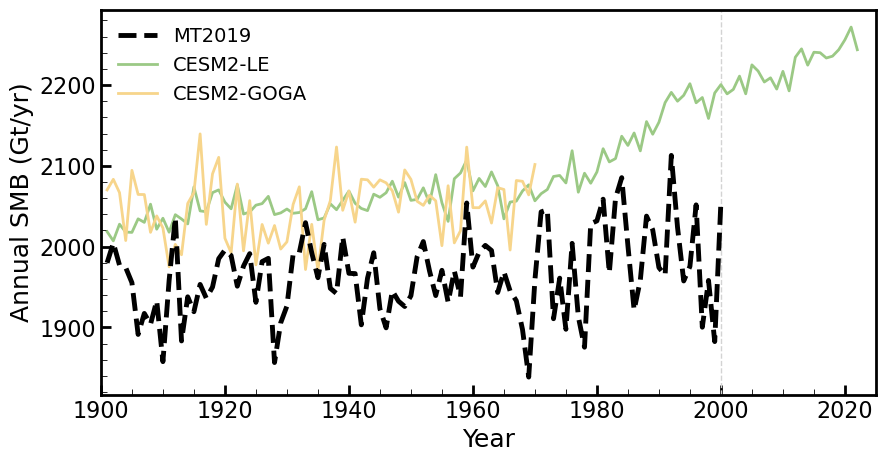

In [13]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(5, 9)
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 18
size_legend = 14
width_line = 2
width_box = 1.9

ax1 = plt.subplot(gs[0:5,0:9])

plt.axvline(x=2000, linestyle="--", color="lightgray", linewidth=1)
ax1.plot(SMB_MT_int_yearly.year, SMB_MT_int_yearly, color="black", linestyle="--", linewidth=width_line+1.5, label="MT2019", zorder=5)
ax1.plot(SMB_LE_int_yearly.year, SMB_LE_int_yearly, color="#9BC985", linewidth=width_line, label="CESM2-LE")
ax1.plot(SMB_GOGA_int_yearly.year, SMB_GOGA_int_yearly, color="#F7D58B", linewidth=width_line, label="CESM2-GOGA")

ax1.legend(loc="best", frameon=False, prop={"size": size_legend}, ncol=1)

ax1.set_xlim([1900, 2025])
#ax1.set_ylim([-15*f09_ocn_area/1e12, 40*f09_ocn_area/1e12])
ax1.set_xlabel("Year", fontsize=size_label)
ax1.set_ylabel("Annual SMB (Gt/yr)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
# ax1.set_yticks([-1000, -500, 0, 500])
ax1.tick_params(labelsize=size_tick)

plt.savefig(
    "tseries_AIS_SMB_check_before_regression.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

## Plot

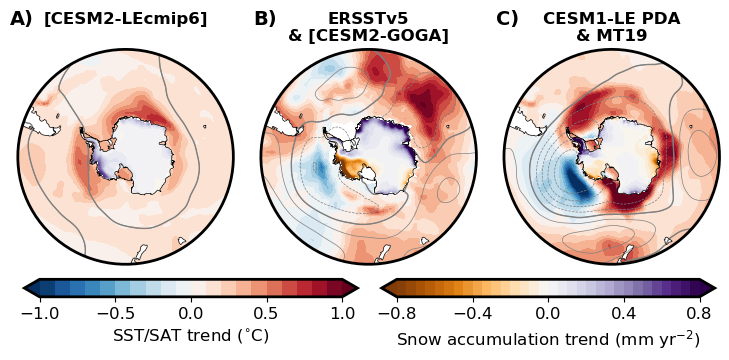

In [18]:
## Add SST and PSL trends
fig=plt.figure(figsize=(9,3.5))
gs=GridSpec(1,3)
plt.rcParams['axes.titlepad'] =14

level_SMB = np.arange(-0.8, 0.81, 0.05)
ticks_SMB = np.arange(-0.8, 0.81, 0.4)

level_SST = np.arange(-1., 1.01, 0.1)
ticks_SST = np.arange(-1., 1.01, 0.5)

#level_PSL = np.arange(0-1.5*60, 0+1.5*61, 1.5)
level_PSL = np.arange(0-1*100, 0+1*100, 1)
level_PSL2 = np.arange(0-2*100, 0+2*100, 2)
level_PSL0 = np.arange(-100., 100.1, 100.)

size_title = 12
size_label = 12
size_tick = 12
size_text = 14
width_contour = 0.5

cmap1 = 'RdBu_r'
cmap2 = 'PuOr'

######################### Subplot1 #########################
ax1 = plt.subplot(gs[0], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax1, -40)

ax1.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax1.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im1a = ax1.contourf(lon_full, lat, SST_LEcmip6_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im1b = ax1.contourf(lon_full, lat, slope_SMB_LE_full_1901_1970, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im1c = ax1.contour(lon_full, lat, PSL_LEcmip6_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im1d = ax1.contour(lon_full, lat, PSL_LEcmip6_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im3b, level_PSL[1::2], fontsize=6)

ax1.text(-6500000, 7400000, 'A)', fontsize=size_text, fontweight='bold')
ax1.set_title('[CESM2-LEcmip6]\n'
              ' ', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot2 #########################
ax2 = plt.subplot(gs[1], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax2, -40)

ax2.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax2.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im2a = ax2.contourf(lon_ERSST_full, lat_ERSST, SST_ERSST_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im2b = ax2.contourf(lon_full, lat, slope_SMB_GOGA_full_1901_1970, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im2c = ax2.contour(lon_full, lat, PSL_GOGA_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im2d = ax2.contour(lon_full, lat, PSL_GOGA_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)
#plt.clabel(im2b, level_PSL[1::2], fontsize=6)

ax2.text(-6500000, 7400000, 'B)', fontsize=size_text, fontweight='bold')
ax2.set_title('ERSSTv5\n'
              '& [CESM2-GOGA]', pad=8, fontsize=size_title, fontweight='bold')

######################### Subplot3 #########################
ax3 = plt.subplot(gs[2], projection=ccrs.SouthPolarStereo())
plot_antarctica_SO(ax3, -40)

ax3.add_feature(cfeature.COASTLINE, lw=0.5, zorder=4)
ax3.add_feature(cfeature.LAND, facecolor='white', zorder=2)
im3a = ax3.contourf(lon_OC21R_full, lat_OC21R, SST_OC21R_full, cmap=cmap1, transform=ccrs.PlateCarree(), levels=level_SST, extend='both', zorder=1)
im3b = ax3.contourf(lon_MT_full, lat_MT, slope_SMB_MT_full_1901_1970, cmap=cmap2, transform=ccrs.PlateCarree(), levels=level_SMB, extend='both', zorder=3)
im3c = ax3.contour(lon_OC21R_full, lat_OC21R, PSL_OC21R_full, levels=level_PSL, linewidths=width_contour, colors=['gray'], transform=crs_ll)
im3d = ax3.contour(lon_OC21R_full, lat_OC21R, PSL_OC21R_full, levels=level_PSL0, linewidths=width_contour+0.5, colors=['gray'], transform=crs_ll)

ax3.text(-6500000, 7400000, 'C)', fontsize=size_text, fontweight='bold')
ax3.set_title('CESM1-LE PDA\n'
              '& MT19', pad=8, fontsize=size_title, fontweight='bold')

#Colorbar
cbar1_ax = fig.add_axes([0.13, 0.15, 0.37, 0.05]) #[from left, from bottom, width, height]
cbar1 = fig.colorbar(im1a, cax=cbar1_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SST, ticks=ticks_SST)
cbar1.ax.tick_params(labelsize=size_tick)
cbar1.set_label('SST/SAT trend ($^{\circ}$C)', size=size_label)

cbar2_ax = fig.add_axes([0.527, 0.15, 0.37, 0.05]) #[from left, from bottom, width, height]
cbar2 = fig.colorbar(im1b, cax=cbar2_ax, orientation='horizontal', pad=.05, extend='both', boundaries=level_SMB, ticks=ticks_SMB)
cbar2.ax.tick_params(labelsize=size_tick)
cbar2.set_label('Snow accumulation trend (mm yr$^{-2}$)', size=size_label)


plt.subplots_adjust(#left=0.1,
                    bottom=0.22,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.09)
plt.savefig(
    'plot/F5_map_AIS_SMB_PSL_SST_trend_p2.jpg',
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #